In [ ]:
#!pip install tensorflow==2.10.0
#!pip install torch==1.12.1
#!pip install transformers==4.20.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd

# Reading the csv file
df = pd.read_csv('/content/drive/MyDrive/RansomwareData.csv')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
y = df[df.columns[2]]

y_binary = df[df.columns[1]].values

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

# Apply the grouping function to the multi-class labels
y_group = y.apply(convert_to_group).values
y_specific = df[df.columns[2]].values

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Define the TransformerBlock class
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Concatenate, Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Add, Lambda
from tensorflow.keras.models import Model, Sequential

# Assume df is your DataFrame and contains your data
X = df.drop([df.columns[0], df.columns[1], df.columns[2]], axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit K-means with the desired number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# One-hot encode cluster labels if desired
cluster_labels_one_hot = tf.keras.utils.to_categorical(cluster_labels)

# Concatenate the cluster labels with the original features
X_w_clusters = np.hstack((X, cluster_labels_one_hot))

# Update the input shape
input_shape_with_clusters = X_w_clusters.shape[1]

from sklearn.model_selection import train_test_split
X_with_clusters, X_test_with_clusters, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X_w_clusters, y, y_binary, y_group, test_size=0.2, random_state=42)

# Create the updated model with additional features
def create_model_with_clusters(input_shape):
    inputs = Input(shape=input_shape)
    dense_reduced = Dense(64, activation="relu")(inputs)
    dense_reduced = Lambda(lambda x: tf.expand_dims(x, axis=1))(dense_reduced)  # Add sequence dimension

    transformer_block = TransformerBlock(embed_dim=64, num_heads=4, ff_dim=64)
    x = transformer_block(dense_reduced)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)  # Pooling to reduce sequence dimension
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    # Classification heads
    binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)
    group_output = Dense(5, activation='softmax', name='group_output')(x)
    specific_output = Dense(12, activation='softmax', name='specific_output')(x)

    model = Model(inputs=inputs, outputs=[binary_output, group_output, specific_output])
    return model

# Create and compile the model with the additional features
model_with_clusters = create_model_with_clusters((input_shape_with_clusters,))
model_with_clusters.compile(optimizer='adam',
                            loss={'binary_output': 'binary_crossentropy', 'group_output': 'sparse_categorical_crossentropy', 'specific_output': 'sparse_categorical_crossentropy'},
                            metrics={'binary_output': 'accuracy', 'group_output': 'accuracy', 'specific_output': 'accuracy'})

# Print the model summary
model_with_clusters.summary()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 30971)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 64)             │      1,982,208 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 1, 64)          │              0 │ dense_8[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_2       │ (None, 1, 64)          │         74,944 │ lambda_2[0][0]         │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ transformer_block_2[0… │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 64)             │          4,160 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_11 (Dropout)      │ (None, 64)             │              0 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ binary_output (Dense)     │ (None, 1)              │             65 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_output (Dense)      │ (None, 5)              │            325 │ dropout_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ specific_output (Dense)   │ (None, 12)             │            780 │ dropout_11[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,062,482 (7.87 MB)

 Trainable params: 2,062,482 (7.87 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Example of training with the combined features approach
history = model_with_clusters.fit(X_with_clusters, [y_train_binary, y_train_group, y_train],
                                  validation_data=(X_test_with_clusters, [y_test_binary, y_test_group, y_test]),
                                  epochs=50, batch_size=32,
                                  callbacks=[early_stopping])


Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - binary_output_accuracy: 0.7908 - group_output_accuracy: 0.5961 - loss: 3.0895 - specific_output_accuracy: 0.5409 - val_binary_output_accuracy: 0.9770 - val_group_output_accuracy: 0.8066 - val_loss: 1.4676 - val_specific_output_accuracy: 0.7738
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - binary_output_accuracy: 0.9756 - group_output_accuracy: 0.8487 - loss: 1.2786 - specific_output_accuracy: 0.7888 - val_binary_output_accuracy: 0.9738 - val_group_output_accuracy: 0.8525 - val_loss: 1.1699 - val_specific_output_accuracy: 0.8230
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - binary_output_accuracy: 0.9880 - group_output_accuracy: 0.9002 - loss: 0.8614 - specific_output_accuracy: 0.8650 - val_binary_output_accuracy: 0.9410 - val_group_output_accuracy: 0.8754 - val_loss: 1.1746 - val_specific_output_accuracy: 0.8000
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - binary_output_accuracy: 0.9895 - group_output_accuracy: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions
predictions = model_with_clusters.predict(X_test_with_clusters)

# Binary predictions and metrics
binary_predictions = (predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)
# Specific predictions and metrics
specific_predictions = np.argmax(predictions[2], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Binary Classification Metrics:
Accuracy: 0.9803
Precision: 0.9826
Recall: 0.9658
F1 Score: 0.9741

Specific Classification Metrics:
Accuracy: 0.8492
Precision: 0.5819
Recall: 0.5194
F1 Score: 0.5115


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions
predictions = model_with_clusters.predict(X_test_with_clusters)

# Binary predictions and metrics
binary_predictions = (predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)
# Specific predictions and metrics
specific_predictions = np.argmax(predictions[2], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Binary Classification Metrics:
Accuracy: 0.9803
Precision: 0.9826
Recall: 0.9658
F1 Score: 0.9741

Specific Classification Metrics:
Accuracy: 0.8492
Precision: 0.5819
Recall: 0.5194
F1 Score: 0.5115


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


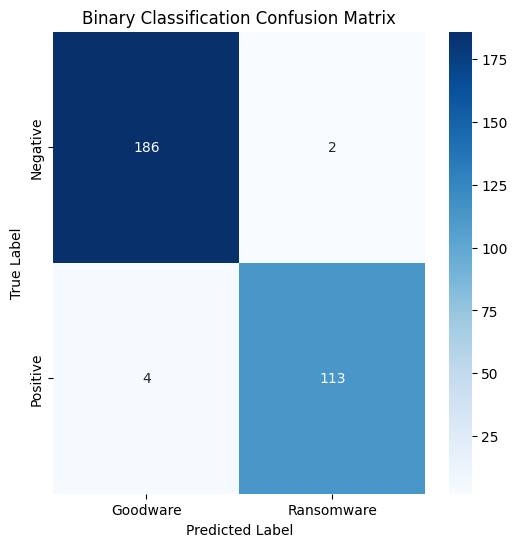

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


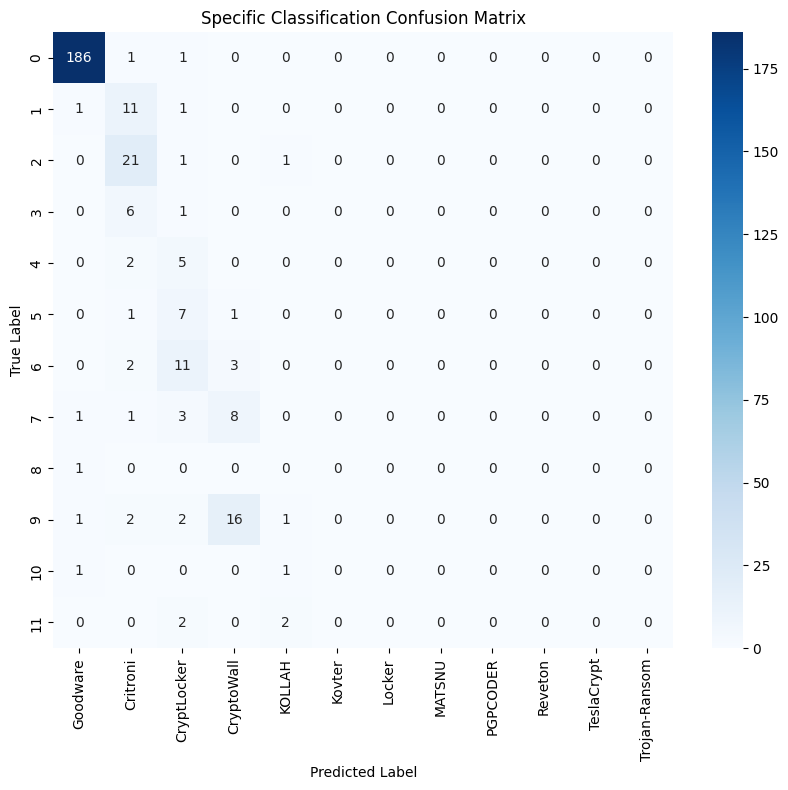

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


# Get predictions for binary classification head
y_binary_pred = model_with_clusters.predict(X_test_with_clusters)[0]
y_binary_pred_classes = (y_binary_pred > 0.5).astype("int32")


cm_binary = confusion_matrix(y_test_binary, y_binary_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sns.heatmap(cm_binary, annot=True, fmt="d", cmap="Blues", xticklabels=['Goodware', 'Ransomware'], yticklabels=['Negative', 'Positive'])
plt.title('Binary Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()




# Get predictions for specific classification head
y_specific_pred = model_with_clusters.predict(X_test_with_clusters)[1]
y_specific_pred_classes = y_specific_pred.argmax(axis=1)

# Compute confusion matrix
cm_specific = confusion_matrix(y_test, y_specific_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
specific_labels = ['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']
sns.heatmap(cm_specific, annot=True, fmt="d", cmap="Blues", xticklabels=specific_labels, yticklabels=range(12))
plt.title('Specific Classification Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
